Повысить прибыль от допродаж в интернет-магазине на 20%.
* 3 места для показа товаров - метрика Precission@3.
* Выдача рекомендаций по идентификатору пользователя.
* Сервис обернут в Docker
* Понятная документация, описание функциональности
* Презентация(Google docs) для менеджера с описанием принципов работы

***Лог событий(events)***
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

***Дерево категорий(category_tree)***
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

***Свойства товаров(item_properties_part1, item_properties_part2)***
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import plotly.express as px

# Визуальная настройка графиков
sns.set_theme("notebook")

In [3]:
# загрузка данных
data = pd.read_csv('data/events.csv')
data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
# загрузка данных
item_properties = pd.concat( [ pd.read_csv('data/item_properties_part1.csv'), pd.read_csv('data/item_properties_part2.csv') ] )

In [5]:
properties = item_properties.copy()
properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [6]:
category = pd.read_csv('data/category_tree.csv')
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


# Исследование данных

## events

In [7]:
#размер таблицы
print(data.shape)

(2756101, 5)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [9]:
#поиск полных дубликатов
data.duplicated().sum()

460

In [10]:
#удаление дубликатов
data.drop_duplicates(inplace=True)

In [11]:
#типы событий в датасете
data.event.value_counts()

event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

In [12]:
#изменение столбца с датой в формат datetime
data['date']=0
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000).replace(microsecond=0))

Какой процент продаж обеспечивают топовые товары (точка отсечения — 1 июля)?

In [13]:
#все продажи до 1 июля, сгруппированные по товарам
date_key = datetime.strptime('2015-07-01', '%Y-%m-%d')
data41 = data[data['date']<=date_key].dropna(subset='transactionid').groupby('itemid')['transactionid'].count()

#топ-3 товаров по продажам до 1-го июля
list_top3 = list(data41.sort_values(ascending=False).head(3).index)
list_top3

[119736, 369447, 7943]

In [14]:
date_key = datetime.strptime('2015-07-02', '%Y-%m-%d')
#все продажи после 1-го июля, сгруппированные по товарам
data_top = data[data['date']>=date_key].dropna(subset='transactionid').groupby('itemid')['transactionid'].count()

#доля продаж товаров топ-3(до1-го июля) после 1-го июля
round((data_top[data_top.index.isin(list_top3)].sum())/data_top.sum()*100, 2)

0.61

Товар с идентификатором 369447 очень активно покупался до 1 июля и ни одного раза после(в пределах датасета).

In [15]:
data.describe()

,timestamp,visitorid,itemid,transactionid,date
count,2.755641e+06,2.755641e+06,2.755641e+06,22457.000000,2755641
mean,1.436424e+12,7.019227e+05,2.349214e+05,8826.497796,2015-07-09 09:46:18.279217664
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000,2015-05-03 06:00:04
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000,2015-06-05 07:21:34
50%,1.436453e+12,7.020600e+05,2.360620e+05,8813.000000,2015-07-09 17:39:51
75%,1.439225e+12,1.053443e+06,3.507140e+05,13224.000000,2015-08-10 19:44:03
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000,2015-09-18 05:59:47
std,3.366334e+09,4.056892e+05,1.341947e+05,5098.996290,NaN


In [16]:
#кодирование целевой переменной
data['target'] = data['event'].apply(lambda x: 0 if x=='view' else 1)

In [17]:
#замена пропусков 0
data['transactionid'] = data['transactionid'].fillna(0)

In [18]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,date,target
0,1433221332117,257597,view,355908,0.0,2015-06-02 08:02:12,0
1,1433224214164,992329,view,248676,0.0,2015-06-02 08:50:14,0
2,1433221999827,111016,view,318965,0.0,2015-06-02 08:13:19,0
3,1433221955914,483717,view,253185,0.0,2015-06-02 08:12:35,0
4,1433221337106,951259,view,367447,0.0,2015-06-02 08:02:17,0


In [19]:
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['dayofweek'] = data['date'].apply(lambda x: x.weekday())
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x==5)|(x==6) else 0)
data['hour'] = data['date'].apply(lambda x: x.hour)
data['minute'] = data['date'].apply(lambda x: x.minute)

In [20]:
def time_day(hour):
    if 0 <= hour < 6: # ночь
        return 1
    elif 6 <= hour < 12: # утро
        return 2
    elif 12 <= hour < 18: # день
        return 3
    else: # вечер
        return 4

In [21]:
data['timeday'] = data['hour'].apply(time_day)

In [22]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,date,target,month,day,dayofweek,weekend,hour,minute,timeday
0,1433221332117,257597,view,355908,0.0,2015-06-02 08:02:12,0,6,2,1,0,8,2,2
1,1433224214164,992329,view,248676,0.0,2015-06-02 08:50:14,0,6,2,1,0,8,50,2
2,1433221999827,111016,view,318965,0.0,2015-06-02 08:13:19,0,6,2,1,0,8,13,2
3,1433221955914,483717,view,253185,0.0,2015-06-02 08:12:35,0,6,2,1,0,8,12,2
4,1433221337106,951259,view,367447,0.0,2015-06-02 08:02:17,0,6,2,1,0,8,2,2


In [23]:
# финальная таблица
df = pd.DataFrame()
df = data.drop(['timestamp', 'transactionid'], axis=1)

In [24]:
df.head()

,visitorid,event,itemid,date,target,month,day,dayofweek,weekend,hour,minute,timeday
0,257597,view,355908,2015-06-02 08:02:12,0,6,2,1,0,8,2,2
1,992329,view,248676,2015-06-02 08:50:14,0,6,2,1,0,8,50,2
2,111016,view,318965,2015-06-02 08:13:19,0,6,2,1,0,8,13,2
3,483717,view,253185,2015-06-02 08:12:35,0,6,2,1,0,8,12,2
4,951259,view,367447,2015-06-02 08:02:17,0,6,2,1,0,8,2,2


Данные с 3 мая по 18 сентября 2015 года. Целевая переменная заменена на бинарную(просмотр - 0, добавление в корзину и покупка - 1). Создана новая таблица, которая будет итоговой, со столбцами пользователь, товар, действие и созданные из даты - месяц, число, день недели, будни-выходные, час, минуты, время дня.

## item_properties

In [25]:
print(properties.shape)

(20275902, 4)


In [26]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [27]:
#поиск полных дубликатов
properties.duplicated().sum()

0

In [28]:
#изменение столбца с датой в формат datetime
properties['date']=0
properties['date'] = properties['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000).replace(microsecond=0))

In [29]:
properties.describe()

,timestamp,itemid,date
count,2.027590e+07,2.027590e+07,20275902
mean,1.435157e+12,2.333904e+05,2015-06-24 17:42:23.682881536
min,1.431227e+12,0.000000e+00,2015-05-10 06:00:00
25%,1.432436e+12,1.165160e+05,2015-05-24 06:00:00
50%,1.433646e+12,2.334830e+05,2015-06-07 06:00:00
75%,1.437880e+12,3.503040e+05,2015-07-26 06:00:00
max,1.442113e+12,4.668660e+05,2015-09-13 06:00:00
std,3.327798e+09,1.348452e+05,NaN


In [30]:
properties.describe(include='object')

,property,value
count,20275902,20275902
unique,1104,1966868
top,888,769062
freq,3000398,1537247


In [31]:
properties.head()

,timestamp,itemid,property,value,date
0,1435460400000,460429,categoryid,1338,2015-06-28 06:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 06:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 06:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 06:00:00
4,1431831600000,156781,917,828513,2015-05-17 06:00:00


In [32]:
#сортировка по дате, чтобы из всех дубликатов оставались последние добавленные
properties = properties.sort_values('date', ascending=False)

In [33]:
# уникальные пары свойство-товар
properties_noduplicate = properties.drop_duplicates(['property', 'itemid'])

In [34]:
# количество уникальных идентификаторов товаров
properties.itemid.nunique()

417053

In [35]:
# ранжирование свойств по частоте
properties_50 = properties_noduplicate.groupby('property')['itemid'].count().sort_values(ascending=False)

In [36]:
list_drop = properties_50[properties_50==properties.itemid.nunique()].index # список свойств, которые есть не у всех товаров
properties_50.drop(list_drop, axis=0, inplace=True) # удаление предыдущих свойств
properties_50 = properties_50[:50] # выбор 50-ти самых часто встречающихся свойств

Есть свойства которые встречаются у всех товаров, но они либо имеют 1 значение, либо очень много, из-за этого не получится использовать значения свойств. Попробую использовать таблицу со свойствами для добавления наличия свойства у товара(за исключением свойств, которые есть у всех)

In [37]:
# удаление товаров, для которых нет свойств(никаких, в том числе )
list_drop = list(df[~df.itemid.isin(list(properties.itemid.unique()))].index)
print(f'Процент товаров c отсутствующими свойствами - {round(len(df)/len(list_drop), 2)}%')
df.drop(list_drop, axis=0, inplace=True)

Процент товаров c отсутствующими свойствами - 10.78%


процент небольшой, датасет объемный, думаю лучше всего подойдёт удаление этих товаров

In [38]:
# добавление столбцов со свойствами(1-есть, 0-нет)
for i in properties_50.index:
    temp = pd.DataFrame(properties_noduplicate[properties_noduplicate.property==i]['itemid'], columns=['itemid'])
    temp[f'property_{i}'] = 1
    df = df.merge(temp, on='itemid', how='left').fillna(0)

## Корреляция

In [39]:
# таблица корреляций
df_corr = df.drop('event', axis=1).corr()

Text(0.5, 1.0, 'Тепловая карта корреляции')

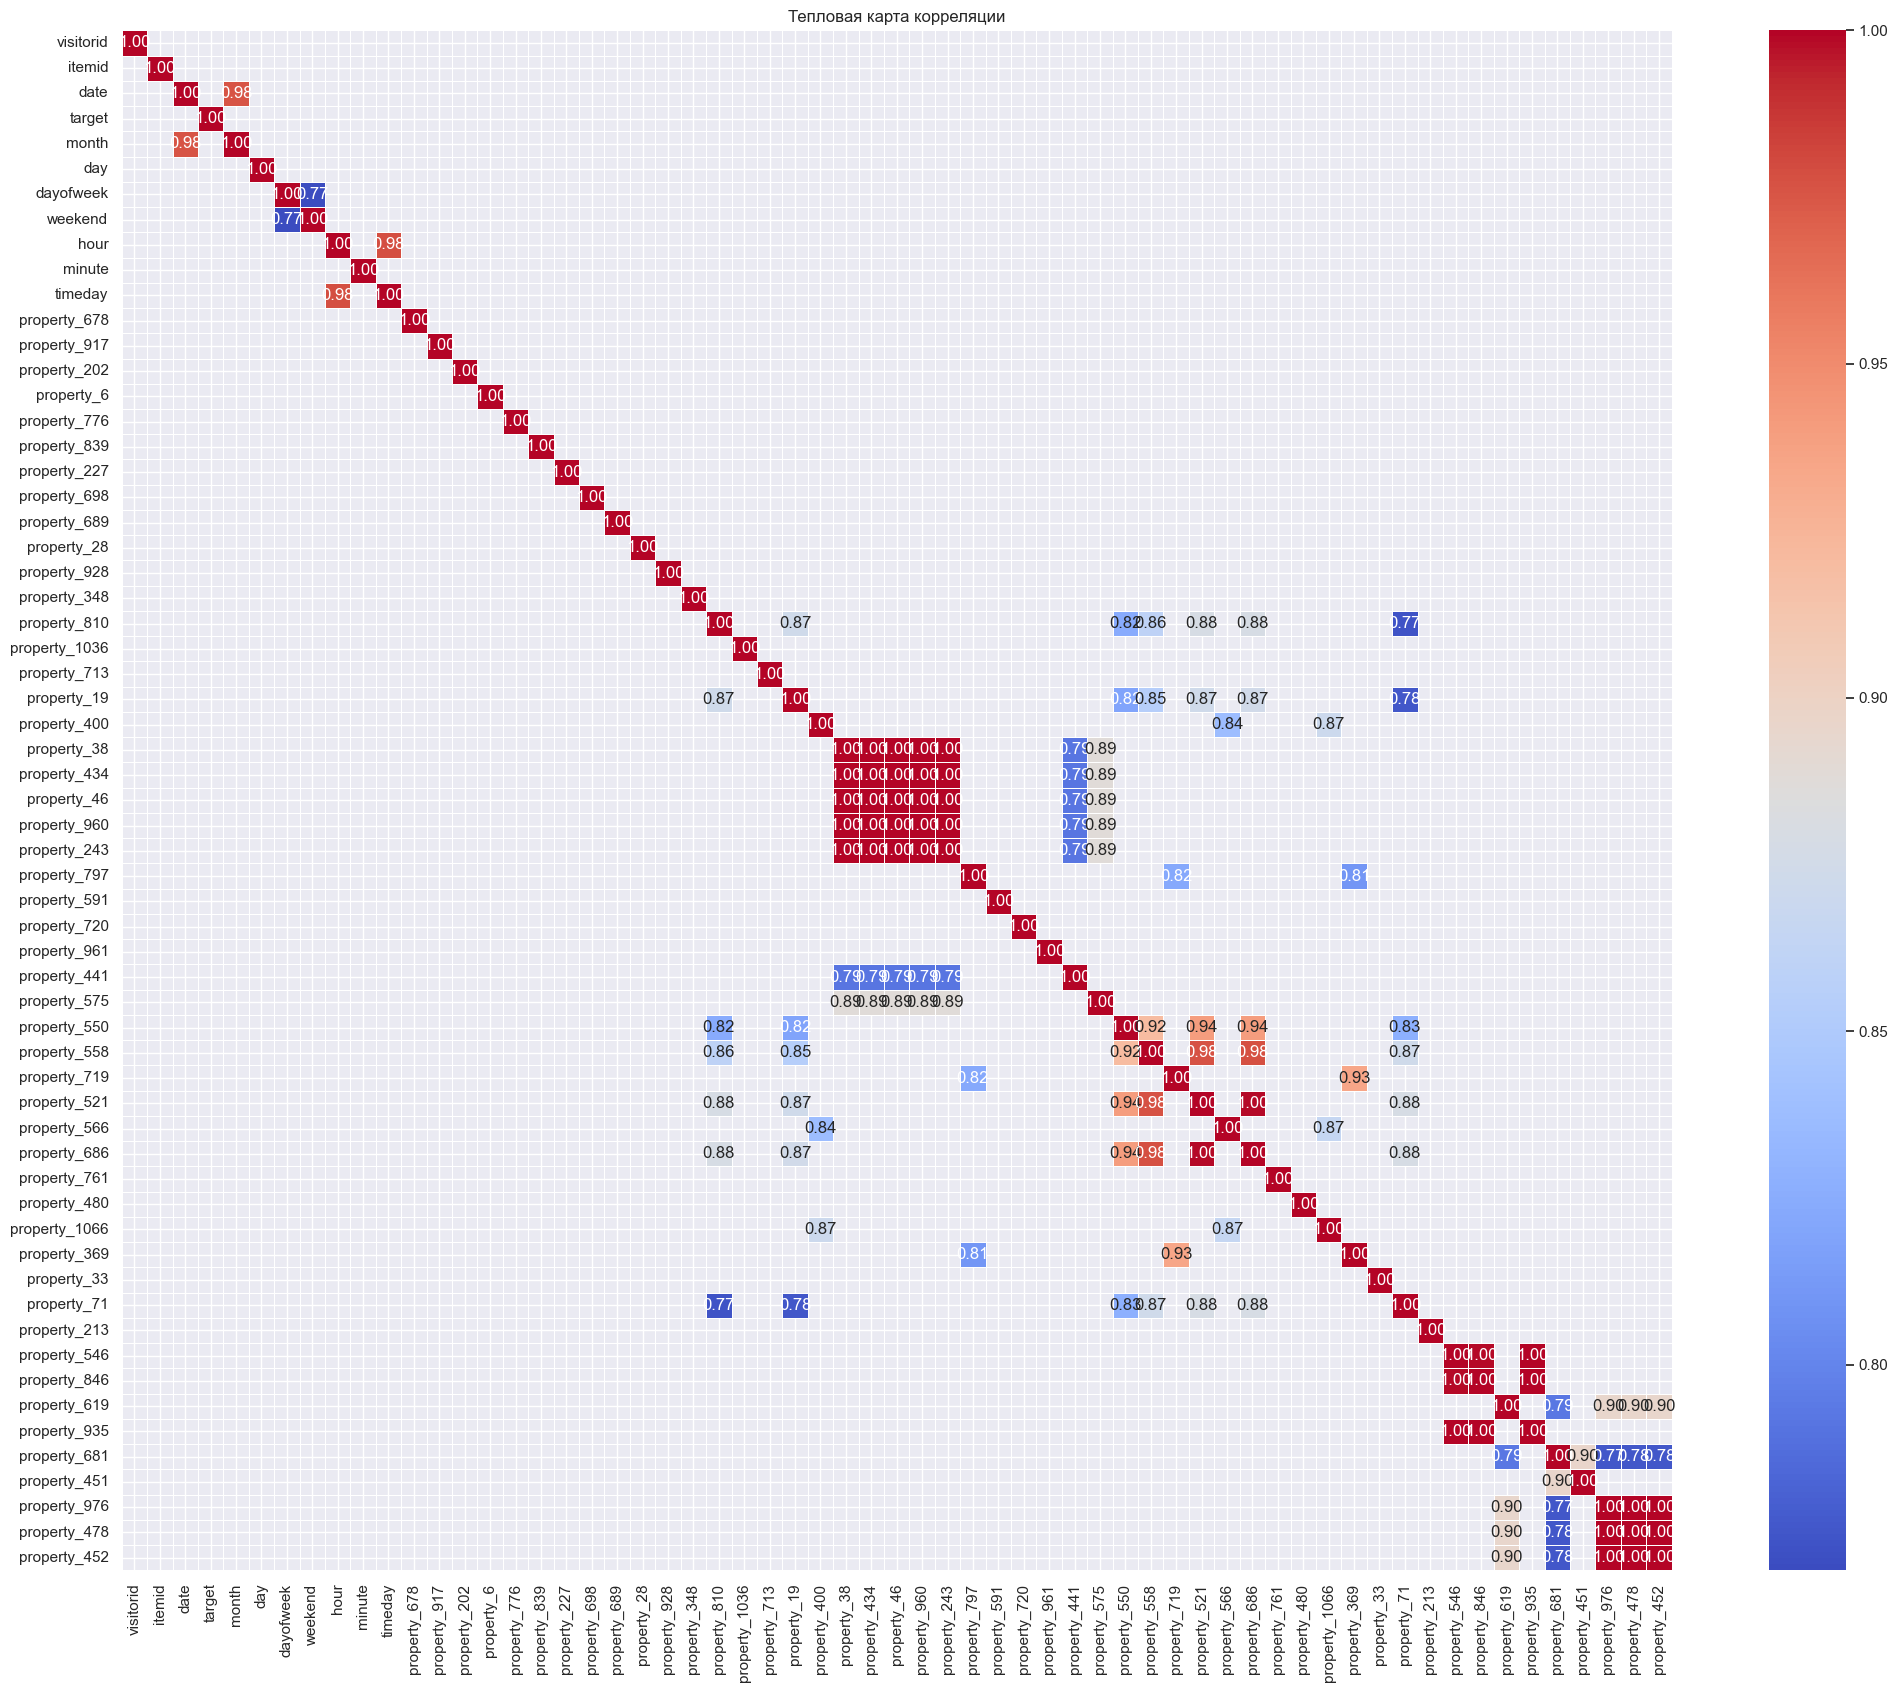

In [40]:
fig = plt.figure(figsize = (25,20))

ax = sns.heatmap(df_corr[0.7<=df_corr.abs()], fmt='.2f', linewidths=.4, cmap='coolwarm', annot=True)

ax.set_title('Тепловая карта корреляции')

In [41]:
# список столбцов в порядке возрастания корреляции c целевой переменной
df_corr_clean = df_corr.copy()
df_corr_clean.target = abs(df_corr_clean.target)
list_corr_sort = pd.DataFrame(df_corr_clean.sort_values('target').index, columns=['name']).reset_index()

In [42]:
list_corr_clean = ['visitorid', 'target', 'itemid', 'date', 'event']

for i in list_corr_sort.name: # имена всех столбцов
    if i in list_corr_clean:
        continue
    else:
        temp = df_corr[abs(df_corr[i])>0.7][i].index # имена столбцов c сильной корреляцией между собой
        temp = pd.DataFrame(temp, columns=['name']) # таблица c именами скоррелированных столбцов
        temp = temp.merge(list_corr_sort, on='name', how='left') # добавление номера в ранжированном списке по корреляции c целевой переменнной
        list_corr_clean.append(temp.sort_values('index', ascending=False).iloc[0, 0]) # сортировка по корреляции c целевой переменной
    
list_corr_clean = list(set(list_corr_clean)) # удаление дубликатов из финального списка столбцов

In [43]:
df = df[list_corr_clean]

In [44]:
df.head()

,property_719,property_713,property_591,property_521,property_213,property_960,property_227,property_961,target,property_761,...,property_451,property_1036,property_839,property_678,property_202,property_348,property_480,property_928,property_720,visitorid
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,257597
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,992329
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,483717
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,951259
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,972639


Данные с 10 мая по 13 сентября 2015 года.

## category_tree

In [45]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [46]:
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [47]:
# рекурсивная функция для расчета вложенности категорий
def tree(x, list_parent=[]):
    df_tree = x.copy()
    if df_tree.shape[1] < 3: # первая итерация
        df_tree['nesting'] = 0 # столбец вложенности
        df_parent = df_tree[df_tree.parentid.isna()] # df c категориями начального уровня
        list_parent = list(df_parent['categoryid'].values) # список категорий начального уровня
        # объединение начальной категории c меткой 0 и значений отправленных на дальнейшую обработку
        print(df_tree[~df_tree.parentid.isna()].shape)
        return pd.concat([df_parent, tree(df_tree[~df_tree.parentid.isna()], list_parent)])
    else:
        while not x.empty: # пока не пустой
            df_tree['nesting'] +=1 # прибавление вложенности
            df_parent = df_tree[df_tree['parentid'].isin(list_parent)] # df со значениями у которых родители есть в списке
            list_parent.extend(list(df_parent['categoryid'].values)) # добавление значений чьи родители в списке
            # объединение значений, остающихся на этом уровне, cо значениями у которых родителей нет в списке(после обработки)
            print(df_tree[~df_tree['categoryid'].isin(list_parent)].shape)
            return pd.concat([df_parent, tree(df_tree[~df_tree['categoryid'].isin(list_parent)], list_parent)])

In [48]:
category = tree(category)

(1644, 3)
(1470, 3)
(768, 3)
(103, 3)
(13, 3)
(0, 3)


In [49]:
# распределение вложенности
category.nesting.value_counts()

nesting
2    702
3    665
1    174
4     90
0     25
5     13
Name: count, dtype: int64

In [50]:
category.describe()

,categoryid,parentid,nesting
count,1669.000000,1644.000000,1669.000000
mean,849.285201,847.571168,2.395446
std,490.195116,505.058485,0.832135
min,0.000000,8.000000,0.000000
25%,427.000000,381.000000,2.000000
50%,848.000000,866.000000,2.000000
75%,1273.000000,1291.000000,3.000000
max,1698.000000,1698.000000,5.000000


In [51]:
# таблица связывающая itemid и categoryid
df_category = properties[properties['property']=='categoryid'][['itemid', 'value', 'date']].drop_duplicates()
df_category['categoryid'] = df_category.value.astype('int') # изменение типа
df_category.drop('value', axis=1, inplace=True)
df_category = df_category.merge(category.drop('parentid', axis=1), on='categoryid', how='left')

In [52]:
#сортировка по дате, чтобы из всех дубликатов оставались последние добавленные
df_category = df_category.sort_values('date')
df_category = df_category.drop_duplicates(['itemid'])

In [53]:
# добавление столбца c вложенностью категорий и столбца c категорией
df = df.merge(df_category[['itemid', 'categoryid', 'nesting']], on=['itemid'], how='left')

## Признаки для пользователя

In [54]:
df.event.value_counts()

event
view           2409950
addtocart        68133
transaction      21982
Name: count, dtype: int64

In [56]:
# просмотры пользователя в выходные или нет
user_view_weekend = df[df.event=='view'].groupby('visitorid')['weekend'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [57]:
# время дня, когда пользователь чаще всего просматривал товары
user_view_timeday = df[df.event=='view'].groupby('visitorid')['timeday'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [58]:
# наиболее просматриваемая категория
user_view_category = df[df.event=='view'].groupby('visitorid')['categoryid'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [59]:
# покупки(и добавление в корзину) пользователя в выходные или нет
user_notview_weekend = df[~(df.event=='view')].groupby('visitorid')['weekend'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [60]:
# время дня, когда пользователь чаще всего покупал(добавлял в корзину) товары
user_notview_timeday = df[~(df.event=='view')].groupby('visitorid')['timeday'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [61]:
# пользователь чаще всего покупал(добавлял в корзину) из этой категории
user_notview_category = df[~(df.event=='view')].groupby('visitorid')['categoryid'].agg(lambda x: x.value_counts().index[0]).reset_index()

In [62]:
# изменение названий столбцов
user_view_weekend.rename(columns={'weekend':'usertop_weekend'}, inplace=True)
user_view_timeday.rename(columns={'timeday':'usertop_timeday'}, inplace=True)
user_view_category.rename(columns={'categoryid':'usertop_category'}, inplace=True)

У некоторых пользователей нет действия просмотра, предполагаю пользователь мог добавить в корзину товар раньше исследуемого периода и зайдя просто купить, таких действий около 5-ти тысяч, такие пропуски заполню теми же пунктами, но отфильтрованными положительному целевому признаку.

In [63]:
# изменение имени столбца в таблицах для заполнения пропусков
user_notview_weekend.rename(columns={'weekend':'usertop_weekend'}, inplace=True)
user_notview_timeday.rename(columns={'timeday':'usertop_timeday'}, inplace=True)
user_notview_category.rename(columns={'categoryid':'usertop_category'}, inplace=True)

In [64]:
# добавление признаков для пользователя
df = df.merge(user_view_weekend, on=['visitorid'], how='left')
df = df.merge(user_view_timeday, on=['visitorid'], how='left')
df = df.merge(user_view_category, on=['visitorid'], how='left')

In [65]:
# корректировка таблиц для заполнения пропусков до состояния индекс основной таблицы-значение признака
user_notview_weekend = user_notview_weekend.merge(df['visitorid'].reset_index(), on='visitorid', how='left')
user_notview_weekend = user_notview_weekend.set_index('index').drop('visitorid', axis=1)

user_notview_timeday = user_notview_timeday.merge(df['visitorid'].reset_index(), on='visitorid', how='left')
user_notview_timeday = user_notview_timeday.set_index('index').drop('visitorid', axis=1)

user_notview_category = user_notview_category.merge(df['visitorid'].reset_index(), on='visitorid', how='left')
user_notview_category = user_notview_category.set_index('index').drop('visitorid', axis=1)

In [67]:
# словари для заполнения пропусков
dict_weekend = dict(zip(user_notview_weekend.index, user_notview_weekend.usertop_weekend))
dict_timeday = dict(zip(user_notview_timeday.index, user_notview_timeday.usertop_timeday))
dict_category = dict(zip(user_notview_category.index, user_notview_category.usertop_category))

In [68]:
# заполнение пропусков
df.fillna({'usertop_weekend':dict_weekend, 'usertop_timeday':dict_timeday, 'usertop_category':dict_category}, inplace=True)

In [69]:
# проверка отсутствия пропусков
print(df['usertop_weekend'].isnull().sum())
print(df['usertop_timeday'].isnull().sum())
print(df['usertop_category'].isnull().sum())

0
0
0


## Статистические тесты

### Зависимость вложенности и целевой переменной
* Нулевая гипотеза: признаки Вложенность и Целевая переменная независимы.
* Альтернативная гипотеза: признаки Вложенность и Целевая переменная взаимосвязаны.

In [70]:
alpha = 0.05
table = pd.crosstab(df['nesting'], df['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 3.062671157389095e-112
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### Зависимость наличия у товара свойства 720 и целевой переменной
* Нулевая гипотеза: признаки свойство 720 и целевая переменная независимы.
* Альтернативная гипотеза: признаки свойство 720 и целевая переменная взаимосвязаны.

In [71]:
alpha = 0.05
table = pd.crosstab(df['property_720'], df['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.29475292379330165
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Зависимость наличия у товара свойства 480 и целевой переменной
* Нулевая гипотеза: признаки свойство 480 и целевая переменная независимы.
* Альтернативная гипотеза: признаки свойство 480 и целевая переменная взаимосвязаны.

In [72]:
alpha = 0.05
table = pd.crosstab(df['property_480'], df['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 8.36720532329304e-05
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### Зависимость самой просматриваемой пользователем категории и целевой переменной
* Нулевая гипотеза: признаки самая просматриваемая категория и целевая переменная независимы.
* Альтернативная гипотеза: признаки самая просматриваемая категория и целевая переменная взаимосвязаны.

In [73]:
alpha = 0.05
table = pd.crosstab(df['usertop_category'], df['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### Зависимость категории товара и целевой переменной
* Нулевая гипотеза: признаки категория товара и целевая переменная независимы.
* Альтернативная гипотеза: признаки категория товара и целевая переменная взаимосвязаны.

In [74]:
alpha = 0.05
table = pd.crosstab(df['categoryid'], df['target'])
_, p, _, _ = stats.chi2_contingency(table)
print(f'p-value = {p}')
# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


# Валидация

In [75]:
df = df.sort_values('date')

In [76]:
df_temp = df.drop(['date', 'event'], axis=1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_temp.drop('target', axis=1), df_temp['target'], test_size=0.3, shuffle=False)

In [78]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1750045, 39) (1750045,)
(750020, 39) (750020,)
